# Important! 
When initially opening the notebook there should be a text to the right of the "Help" menu saying "Changes will not be saved". 
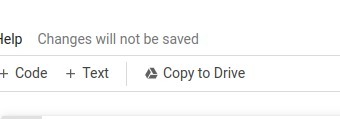

To ensure you can make changes to the notebook save a copy of it to your own drive and work on that one. You can do that by going to "File" -> "Save a copy in Drive".

**Failing to do so will result in code loss!**

 **Note** Make sure you are the only one that has access to it!


In [3]:
#@markdown #Image Processing - 67829. { display-mode: "form" }
#@markdown ##Exercise 5:  Deep Style Image Prior
#@markdown ##Due date: 13.01.2022 at 23:59
#@title{ display-mode: "form" }

#@markdown
#@markdown This exercise is a bit different than the rest of the exercises in the course.
#@markdown The submissions will be a PDF file with your answers and results to the exercise 
#@markdown as well as some files so that we can verify the authenticity of your results.
#@markdown This notebook provides the basic code, but you do not need to adhere to some specific API 
#@markdown and we will not be running unit tests on your code. 
#@markdown We will however, be going over your code and running it manually. 
#@markdown Moreover, we will be running tests to ensure the authenticity of your solution and detect plagiarism
#@markdown
#@markdown
#@markdown Before you start working on the exercise it is recommended that you review the lecture slides covering neural networks,
#@markdown
#@markdown 
#@markdown **NOTE**: Neural networks are typically trained on GPUs, without GPUs training takes much longer. 
#@markdown To enable GPU tranining click on "Runtime" -> "Change runtime type" -> "GPU" -> "SAVE".
#@markdown
#@markdown **NOTE**: A short guide on debugging your code using colab is availble [here](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.06-Errors-and-Debugging.ipynb#scrollTo=qnIn-rWFqoww).

#@markdown But first, we have to download all of the dependencies and install them.
#@markdown Play this cell to download it and get everything ready. markdown This may take a few minutes.

 
!mkdir impr_ex5_resources
%cd impr_ex5_resources
#!wget "https://www.cs.huji.ac.il/~impr/shape_predictor_68_face_landmarks.dat" -O shape_predictor_68_face_landmarks.dat 
#!wget "https://www.cs.huji.ac.il/~impr/align_faces.py" -O align_faces.py 
!wget "https://www.cs.huji.ac.il/~impr/stylegan2-ada-pytorch.tar" -O stylegan2-ada-pytorch.tar
!tar -xvf stylegan2-ada-pytorch.tar
!rm -f stylegan2-ada-pytorch.tar

import sys
ROOT_PATH="/content/impr_ex5_resources/stylegan2-ada-pytorch"
sys.path.append(ROOT_PATH)


!pip install ninja
!pip install mediapy
CHECKPOINTS_PATH = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"



import copy
import os
from time import perf_counter
import click
import imageio
import numpy as np
import PIL.Image
import torch
import torch.nn.functional as F
import torchvision.transforms as T

import dnnlib
import legacy
import numpy as np
from skimage.draw import line
from torch.nn.functional import conv2d,conv1d
from torchvision.transforms import Grayscale
import mediapy as media
from IPython.display import clear_output


/content/impr_ex5_resources
--2022-01-17 11:01:04--  https://www.cs.huji.ac.il/~impr/stylegan2-ada-pytorch.tar
Resolving www.cs.huji.ac.il (www.cs.huji.ac.il)... 132.65.118.16
Connecting to www.cs.huji.ac.il (www.cs.huji.ac.il)|132.65.118.16|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://www.cs.huji.ac.il/w~impr/stylegan2-ada-pytorch.tar [following]
--2022-01-17 11:01:05--  https://www.cs.huji.ac.il/w~impr/stylegan2-ada-pytorch.tar
Reusing existing connection to www.cs.huji.ac.il:443.
HTTP request sent, awaiting response... 200 OK
Length: 100364800 (96M) [application/x-tar]
Saving to: ‘stylegan2-ada-pytorch.tar’

stylegan2-ada-pytor 100%[===================>]  95.71M  16.6MB/s    in 6.7s    

2022-01-17 11:01:12 (14.4 MB/s) - ‘stylegan2-ada-pytorch.tar’ saved [100364800/100364800]

stylegan2-ada-pytorch/
stylegan2-ada-pytorch/metrics/
stylegan2-ada-pytorch/._dataset_tool.py
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xat

# Mounting Google Drive

In [4]:
#@markdown **NOTE**: It is strongly advised you save your results to Google 
#@markdown Drive as they will be deleted from Colab once it restarts. 
#@markdown To connect Google Drive run this cell. 
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Below is the root dir of your Google Drive. To choose the destenation of the dir to save and read from, create it in your Google Drive and add the relative path to the "GDRIVE_SAVE_REL_PATH" variable below.

In [5]:
ROOT_GDRIVE_PATH="/content/gdrive/MyDrive/"
GDRIVE_SAVE_REL_PATH = "IMPRO_EX5_2021"
FULL_GDRIVE_SAVE_PATH = ROOT_GDRIVE_PATH + GDRIVE_SAVE_REL_PATH

# General Variables

In [6]:
GAUSSIAN_BLUR_DEGRADATION= 'GAUSSIAN_BLUR_DEGRADATION'
GRAYSCALE_DEGRADATION = 'GRAYSCALE_DEGRADATION'
INPAINTING_DEGRADATION = 'INPAINTING_DEGRADATION'
DENOISING_DEGRADATION = 'DENOISING_DEGRADATION'
NO_DEGRADATION= 'NO_DEGRADATION'


# Image Alignment

In [ ]:
# The align_faces.py script takes in an input image path, an output image path, and a dat file path. The dat file is already downloaded for you, so leave it as it is. 
# It is advised that you save the files to google drive as restarting Colab will erase them.
!python "$ROOT_PATH/align_faces/align_faces.py" '/content/gdrive/MyDrive/IMPRO_EX5_2021/input_images/my_face.png' '/content/gdrive/MyDrive/IMPRO_EX5_2021/input_images/my_face_aligned.png' "$ROOT_PATH/align_faces/shape_predictor_68_face_landmarks.dat"

Number of faces detected: 1
Detection 0: Left: 617 Top: 937 Right: 1575 Bottom: 1895
Part 0: (614, 1205), Part 1: (624, 1335) ...


# Degradation Functions 

In [7]:
    # ********************************************************************************************************
    # ******************                   NEED TO ADD DEGRADATION FUNCTIONS                ******************
    # ********************************************************************************************************

    # I. GAUSSIAN_BLUR_DEGRADATION

    def gaussian_kernel(filter_size):
      basis = filter_vec = torch.tensor([0.5, 0.5], dtype=torch.float32).reshape(1, 1, 2)
      for i in range(filter_size - 2):
          filter_vec = conv1d(filter_vec, basis, padding=1)
      return filter_vec
      # return filter_vec / torch.sum(filter_vec)


    def blur_spatial(im, filter_vec):
        filter_vec = filter_vec.repeat(3, 1, 1, 1)
        padding = filter_vec.shape[3]//2
        blurred_im = conv2d(im, filter_vec , padding=[0,padding], groups=3)
        blurred_im = conv2d(blurred_im, filter_vec.permute(0, 1, 3, 2), padding=[padding,0], groups=3)

        return blurred_im

    # II. GRAYSCALE_DEGRADATION

    # III. INPAINTING_DEGRADATION

# GAN Inversion

In [14]:
def run_latent_optimization(outdir,
    degradation_mode,
    G,
    imgs_to_disply_dict,
    target: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
    *,
    num_steps                  = 1000,
    w_avg_samples              = 10000,
    initial_learning_rate      = 0.1,
    initial_noise_factor       = 0.05,
    lr_rampdown_length         = 0.25,
    lr_rampup_length           = 0.05,
    noise_ramp_length          = 0.75,
    regularize_noise_weight    = 1e5,
    latent_dist_reg_weight     = 0.001,
    blur_kernel                = None,
    mask                       = None,
    device: torch.device
    
):
    assert target.shape == (G.img_channels, G.img_resolution, G.img_resolution)

    if degradation_mode == GAUSSIAN_BLUR_DEGRADATION:
      assert blur_kernel is not None
    if degradation_mode == INPAINTING_DEGRADATION:
      assert mask is not None

    G = copy.deepcopy(G).eval().requires_grad_(False).to(device) # type: ignore
  
    # Compute w stats.
    print(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
    z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim)
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = w_samples.cpu().numpy().astype(np.float32)
    w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 18, C]
    w_avg_original = torch.from_numpy(w_avg).to(device).float()
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

    # Setup noise inputs.
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

    # Load VGG16 feature detector.
    url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
    with dnnlib.util.open_url(url) as f:
        vgg16 = torch.jit.load(f).eval().to(device)
    
    # Features for target image.
    target_images = target.unsqueeze(0).to(device).to(torch.float32)

    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    target_features = vgg16(target_images, resize_images=False, return_lpips=True)

    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) 
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
    loss_out = torch.zeros([num_steps], dtype=torch.float32, device=device)
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)
    
    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    for step in range(num_steps):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Synth image from opt_w
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = w_opt + w_noise
        synth_images = G.synthesis(ws, noise_mode='const')
        
        # Prep to save synth image
        synth_image_save = (synth_images + 1) * (255/2)
        synth_image_save = synth_image_save.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    
    
        # ********************************************************************************************************
        # ******************                   NEED TO FILL IN THE FOLLOWING CODE               ******************
        # ********************************************************************************************************
        if  degradation_mode == INPAINTING_DEGRADATION:
          assert mask.shape == synth_images.shape
          synth_images *= mask
        elif degradation_mode == GRAYSCALE_DEGRADATION:
          synth_images = Grayscale(num_output_channels=3)(synth_images)
        elif degradation_mode == GAUSSIAN_BLUR_DEGRADATION:
          synth_images = blur_spatial(synth_images, blur_kernel)

        # ********************************************************************************************************
        # ******************                          END CODE TO ADD SECTION                   ******************
        # ********************************************************************************************************
         
        
        # Prep to save and show images
        synth_image_degraded_save = (synth_images + 1) * (255/2)
        synth_image_degraded_save = synth_image_degraded_save.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()  
        
        if step % 20 == 0:
          imgs_to_disply_dict["Generated Image"]=synth_image_save
          imgs_to_disply_dict["Generated Degraded Image"]=synth_image_degraded_save
          clear_output(wait=True)
          media.show_images(imgs_to_disply_dict,height=256)
        if step % 100 == 0:
          PIL.Image.fromarray(synth_image_save, 'RGB').save(f'{outdir}/intermidiate_%d_not_degraded.png'%step)
          PIL.Image.fromarray(synth_image_degraded_save, 'RGB').save(f'{outdir}/intermidiate_%d_degraded.png'%step)


        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        synth_images = (synth_images + 1) * (255/2)
        if synth_images.shape[2] > 256:
            synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

        # Features for synth images.
        synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
        
        # Compute loss
        percep_loss = (target_features - synth_features).square().sum()
        latent_dist_reg = F.l1_loss(w_avg_original, w_opt)
        loss = percep_loss + reg_loss * regularize_noise_weight  + latent_dist_reg_weight * latent_dist_reg


        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        print(f'step {step+1:>4d}/{num_steps}: percep_loss {percep_loss:<4.2f} latent_dist_reg {latent_dist_reg:<4.2f} loss {float(loss):<5.2f}' )

        # Save inverted latent for each optimization step.
        w_out[step] = w_opt.detach()[0]
        loss_out[step] = loss

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()
    
    return w_out, loss_out

In [20]:
def invert_image(degradation_mode,
                   target_fname,
                   outdir,
                   mask_fname = None,
                   seed=303,
                   num_steps=1000,
                   latent_dist_reg_weight=0.001):
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Load networks.
    print('Loading networks from "%s"...' % CHECKPOINTS_PATH)
    device = torch.device('cuda')
    with dnnlib.util.open_url(CHECKPOINTS_PATH) as fp:
        networks = legacy.load_network_pkl(fp)
        G = networks['G_ema'].requires_grad_(False).to(device)
        

    # Load target image.
    if not os.path.exists(outdir):
      os.makedirs(outdir)
    target_pil = PIL.Image.open(target_fname).convert('RGB')
    w, h = target_pil.size
    s = min(w, h)
    target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
    target_pil = target_pil.resize((G.img_resolution, G.img_resolution), PIL.Image.LANCZOS)
    target_uint8 = np.array(target_pil, dtype=np.uint8)
    target = torch.tensor(target_uint8.transpose([2, 0, 1]), device=device), 
    target_images = target[0].unsqueeze(0).to(device).to(torch.float32)

    # ********************************************************************************************************
    # ******************                   NEED TO FILL IN THE FOLLOWING CODE               ******************
    # ********************************************************************************************************
    kernel = None
    mask = None
    if  degradation_mode == INPAINTING_DEGRADATION:
      mask = PIL.Image.open(mask_fname).convert('RGB')
      mask = torch.tensor(T.ToTensor()(mask), dtype=torch.float32, device=device).unsqueeze(0)
      target_images *= mask
    elif degradation_mode == GRAYSCALE_DEGRADATION:
      target_images = Grayscale(num_output_channels=3)(target_images)
    elif degradation_mode == GAUSSIAN_BLUR_DEGRADATION:
      kernel = gaussian_kernel(85).to(device)
      target_images = blur_spatial(target_images, kernel)
      pass
      
    # ********************************************************************************************************
    # ******************                          END CODE TO ADD SECTION                   ******************
    # ********************************************************************************************************

    #Save target image
    target_to_save = target_images.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    PIL.Image.fromarray(target_to_save, 'RGB').save(f'{outdir}/original_degraded_image.png')
    imgs_to_disply_dict = {
        "Original Image":target_uint8,
        "Original Degraded Image":target_to_save,
              }

    # Run latent optimization
    print('Run latent optimization')
    start_time = perf_counter()
    optimization_steps, optimization_losses = run_latent_optimization(
        outdir,
        degradation_mode,
        G,
        imgs_to_disply_dict,
        target_images[0],
        num_steps=num_steps,
        device=device,
        latent_dist_reg_weight=latent_dist_reg_weight,
        blur_kernel=kernel,
        mask=mask
    )

    print (f'Elapsed: {(perf_counter()-start_time):.1f} s')
    os.makedirs(outdir, exist_ok=True)

    # Save final inverted image and latent vector.
    inverted_latent = optimization_steps[-1]
    synth_image = G.synthesis(inverted_latent.unsqueeze(0), noise_mode='const')
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    PIL.Image.fromarray(synth_image, 'RGB').save(f'{outdir}/final_inverted_image.png')
    np.savez(f'{outdir}/inverted_latent.npz', latent=inverted_latent.unsqueeze(0).cpu().numpy())

    return optimization_losses

# GAN Inversion with no degradation

**The optimization progressions with over 5 images**


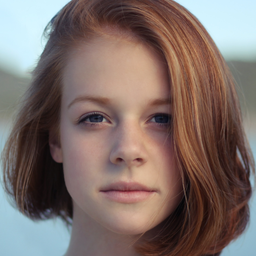
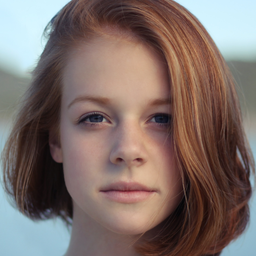
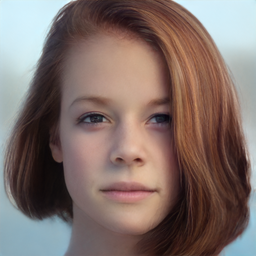
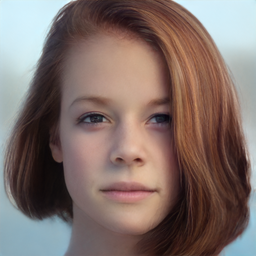

step  781/800: percep_loss 0.10 latent_dist_reg 0.31 loss 0.14 
step  782/800: percep_loss 0.10 latent_dist_reg 0.31 loss 0.14 
step  783/800: percep_loss 0.10 latent_dist_reg 0.31 loss 0.14 
step  784/800: percep_loss 0.10 latent_dist_reg 0.31 loss 0.14 
step  785/800: percep_loss 0.10 latent_dist_reg 0.31 loss 0.14 
step  786/800: percep_loss 0.10 latent_dist_reg 0.31 loss 0.14 
step  787/800: percep_loss 0.10 latent_dist_reg 0.31 loss 0.14 
step  788/800: percep_loss 0.10 latent_dist_reg 0.31 loss 0.14 
step  789/800: percep_loss 0.10 latent_dist_reg 0.31 loss 0.14 
step  790/800: percep_loss 0.10 latent_dist_reg 0.31 loss 0.14 
step  791/800: percep_loss 0.10 latent_dist_reg 0.31 loss 0.14 
step  792/800: percep_loss 0.10 latent_dist_reg 0.31 loss 0.14 
step  793/800: percep_loss 0.10 latent_dist_reg 0.31 loss 0.14 
step  794/800: percep_loss 0.10 latent_dist_reg 0.31 loss 0.14 
step  795/800: percep_loss 0.10 latent_dist_reg 0.31 loss 0.14 
step  796/800: percep_loss 0.10 latent_d

In [18]:
opt_losses = invert_image(degradation_mode=NO_DEGRADATION,
                          target_fname='/content/gdrive/MyDrive/image_const/Christopher_Campbell_aligned.png',
                          outdir='/content/gdrive/MyDrive/image_const',
                          seed=303,
                          num_steps=800,
                          latent_dist_reg_weight=0.1)

**A plot of the optimization loss**

In [10]:
import matplotlib.pyplot as plt

def plot_optimization_loss(loss):
    steps = np.arange(len(loss))
    plt.plot(steps, loss.cpu().detach().numpy(), 'b-')
    plt.xlabel('step')
    plt.xticks(np.arange(0, len(loss) + 1, 100), rotation = (45), fontsize = 10)
    plt.ylabel('loss')
    plt.yscale('log')
    plt.title('The Optimization Loss')
    plt.tight_layout()
    plt.show()
    # plt.savefig('/content/gdrive/MyDrive/IMPRO_EX5_2021/output_images/LossPlot.png')


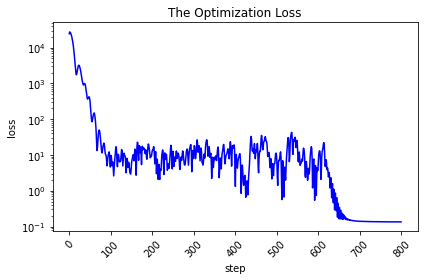

In [19]:
plot_optimization_loss(opt_losses)

# Image Reconstruction Tasks

**Image Deblurring**


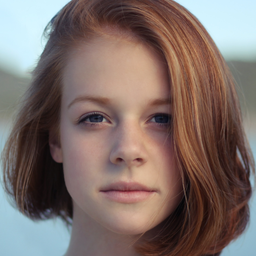
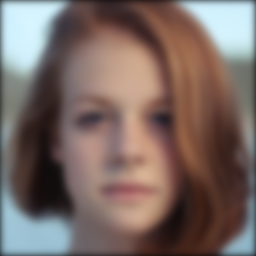
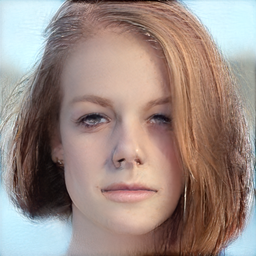
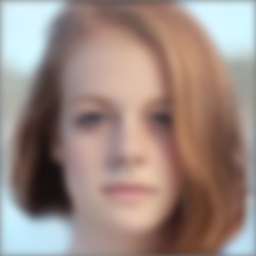

step  981/1000: percep_loss 0.04 latent_dist_reg 0.25 loss 0.06 
step  982/1000: percep_loss 0.04 latent_dist_reg 0.25 loss 0.06 
step  983/1000: percep_loss 0.04 latent_dist_reg 0.25 loss 0.06 
step  984/1000: percep_loss 0.04 latent_dist_reg 0.25 loss 0.06 
step  985/1000: percep_loss 0.04 latent_dist_reg 0.25 loss 0.06 
step  986/1000: percep_loss 0.04 latent_dist_reg 0.25 loss 0.06 
step  987/1000: percep_loss 0.04 latent_dist_reg 0.25 loss 0.06 
step  988/1000: percep_loss 0.04 latent_dist_reg 0.25 loss 0.06 
step  989/1000: percep_loss 0.04 latent_dist_reg 0.25 loss 0.06 
step  990/1000: percep_loss 0.04 latent_dist_reg 0.25 loss 0.06 
step  991/1000: percep_loss 0.04 latent_dist_reg 0.25 loss 0.06 
step  992/1000: percep_loss 0.04 latent_dist_reg 0.25 loss 0.06 
step  993/1000: percep_loss 0.04 latent_dist_reg 0.25 loss 0.06 
step  994/1000: percep_loss 0.04 latent_dist_reg 0.25 loss 0.06 
step  995/1000: percep_loss 0.04 latent_dist_reg 0.25 loss 0.06 
step  996/1000: percep_lo

In [15]:

opt_losses = invert_image(degradation_mode=GAUSSIAN_BLUR_DEGRADATION,
                          target_fname='/content/gdrive/MyDrive/deblurring/im1/Christopher_Campbell_aligned.png',
                          outdir='/content/gdrive/MyDrive/deblurring/im1',
                          seed=303,
                          num_steps=1000,
                          latent_dist_reg_weight=0.1)

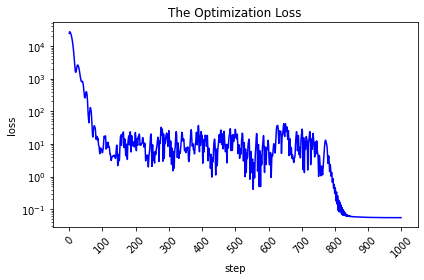

In [12]:
plot_optimization_loss(opt_losses)


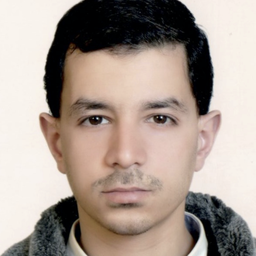
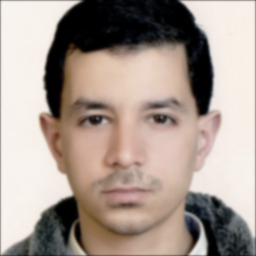
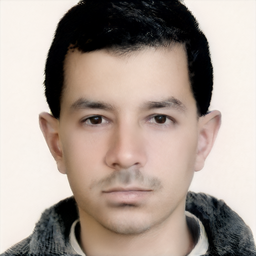
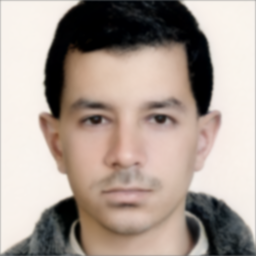

step  981/1000: percep_loss 0.04 latent_dist_reg 0.22 loss 0.06 
step  982/1000: percep_loss 0.04 latent_dist_reg 0.22 loss 0.06 
step  983/1000: percep_loss 0.04 latent_dist_reg 0.22 loss 0.06 
step  984/1000: percep_loss 0.04 latent_dist_reg 0.22 loss 0.06 
step  985/1000: percep_loss 0.04 latent_dist_reg 0.22 loss 0.06 
step  986/1000: percep_loss 0.04 latent_dist_reg 0.22 loss 0.06 
step  987/1000: percep_loss 0.04 latent_dist_reg 0.22 loss 0.06 
step  988/1000: percep_loss 0.04 latent_dist_reg 0.22 loss 0.06 
step  989/1000: percep_loss 0.04 latent_dist_reg 0.22 loss 0.06 
step  990/1000: percep_loss 0.04 latent_dist_reg 0.22 loss 0.06 
step  991/1000: percep_loss 0.04 latent_dist_reg 0.22 loss 0.06 
step  992/1000: percep_loss 0.04 latent_dist_reg 0.22 loss 0.06 
step  993/1000: percep_loss 0.04 latent_dist_reg 0.22 loss 0.06 
step  994/1000: percep_loss 0.04 latent_dist_reg 0.22 loss 0.06 
step  995/1000: percep_loss 0.04 latent_dist_reg 0.22 loss 0.06 
step  996/1000: percep_lo

In [ ]:
opt_losses = invert_image(degradation_mode=GAUSSIAN_BLUR_DEGRADATION,
                          target_fname='/content/gdrive/MyDrive/deblurring/im2/my_face_aligned.png',
                          outdir='/content/gdrive/MyDrive/deblurring/im2',
                          seed=303,
                          num_steps=1000,
                          latent_dist_reg_weight=0.1)

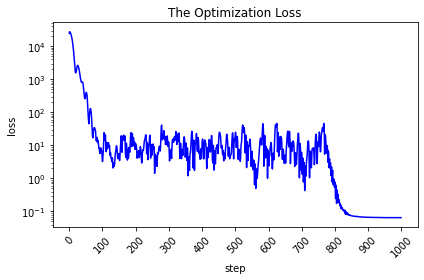

In [ ]:
plot_optimization_loss(opt_losses)

**Deblurring on the given blurry image of Yann LeCun**

In order to run the next cell, comment the line:

`target_images = blur_spatial(target_images, kernel)`

in the function:  `invert_image`  under the section:

`elif degradation_mode == GAUSSIAN_BLUR_DEGRADATION:`





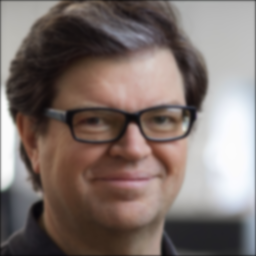
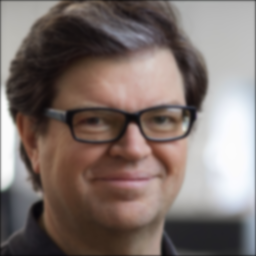
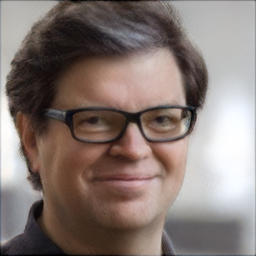
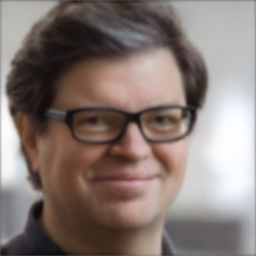

step 1981/2000: percep_loss 0.05 latent_dist_reg 1.36 loss 0.06 
step 1982/2000: percep_loss 0.05 latent_dist_reg 1.36 loss 0.06 
step 1983/2000: percep_loss 0.05 latent_dist_reg 1.36 loss 0.06 
step 1984/2000: percep_loss 0.05 latent_dist_reg 1.36 loss 0.06 
step 1985/2000: percep_loss 0.05 latent_dist_reg 1.36 loss 0.06 
step 1986/2000: percep_loss 0.05 latent_dist_reg 1.36 loss 0.06 
step 1987/2000: percep_loss 0.05 latent_dist_reg 1.36 loss 0.06 
step 1988/2000: percep_loss 0.05 latent_dist_reg 1.36 loss 0.06 
step 1989/2000: percep_loss 0.05 latent_dist_reg 1.36 loss 0.06 
step 1990/2000: percep_loss 0.05 latent_dist_reg 1.36 loss 0.06 
step 1991/2000: percep_loss 0.05 latent_dist_reg 1.36 loss 0.06 
step 1992/2000: percep_loss 0.05 latent_dist_reg 1.36 loss 0.06 
step 1993/2000: percep_loss 0.05 latent_dist_reg 1.36 loss 0.06 
step 1994/2000: percep_loss 0.05 latent_dist_reg 1.36 loss 0.06 
step 1995/2000: percep_loss 0.05 latent_dist_reg 1.36 loss 0.06 
step 1996/2000: percep_lo

In [15]:
opt_losses = invert_image(degradation_mode=GAUSSIAN_BLUR_DEGRADATION,
                          target_fname='/content/gdrive/MyDrive/deblurring/Yann LeCun/yann_lecun_blur.png',
                          outdir='/content/gdrive/MyDrive/deblurring/Yann LeCun',
                          seed=303,
                          num_steps=2000,
                          latent_dist_reg_weight=0.005)

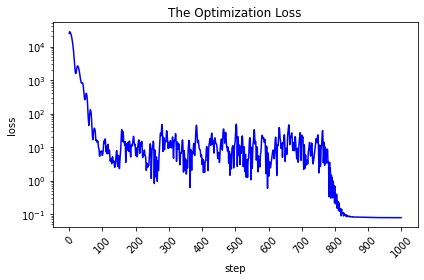

In [ ]:
plot_optimization_loss(opt_losses)

**Image Colorization**


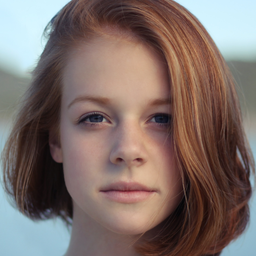
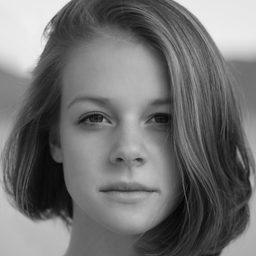
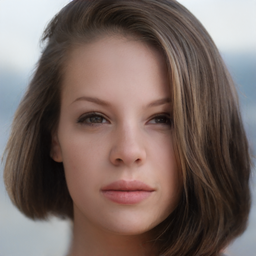
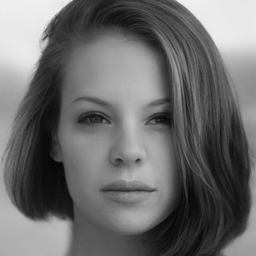

step  881/900: percep_loss 0.15 latent_dist_reg 0.06 loss 0.21 
step  882/900: percep_loss 0.15 latent_dist_reg 0.06 loss 0.21 
step  883/900: percep_loss 0.15 latent_dist_reg 0.06 loss 0.21 
step  884/900: percep_loss 0.15 latent_dist_reg 0.06 loss 0.21 
step  885/900: percep_loss 0.15 latent_dist_reg 0.06 loss 0.21 
step  886/900: percep_loss 0.15 latent_dist_reg 0.06 loss 0.21 
step  887/900: percep_loss 0.15 latent_dist_reg 0.06 loss 0.21 
step  888/900: percep_loss 0.15 latent_dist_reg 0.06 loss 0.21 
step  889/900: percep_loss 0.15 latent_dist_reg 0.06 loss 0.21 
step  890/900: percep_loss 0.15 latent_dist_reg 0.06 loss 0.21 
step  891/900: percep_loss 0.15 latent_dist_reg 0.06 loss 0.21 
step  892/900: percep_loss 0.15 latent_dist_reg 0.06 loss 0.21 
step  893/900: percep_loss 0.15 latent_dist_reg 0.06 loss 0.21 
step  894/900: percep_loss 0.15 latent_dist_reg 0.06 loss 0.21 
step  895/900: percep_loss 0.15 latent_dist_reg 0.06 loss 0.21 
step  896/900: percep_loss 0.15 latent_d

In [ ]:
opt_losses = invert_image(degradation_mode=GRAYSCALE_DEGRADATION,
                          target_fname='/content/gdrive/MyDrive/Colorization/im1/Christopher_Campbell_aligned.png',
                          outdir='/content/gdrive/MyDrive/Colorization/im1',
                          seed=613,
                          num_steps=900,
                          latent_dist_reg_weight=1)

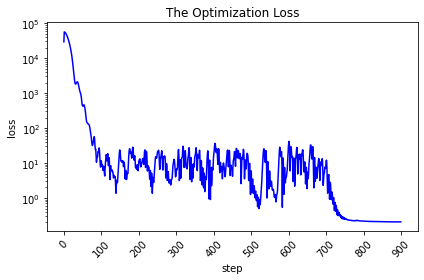

In [ ]:
plot_optimization_loss(opt_losses)


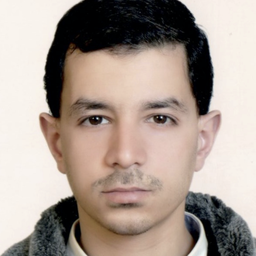
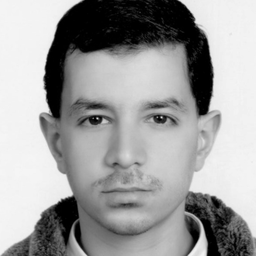
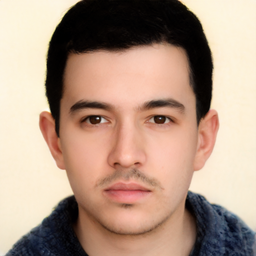
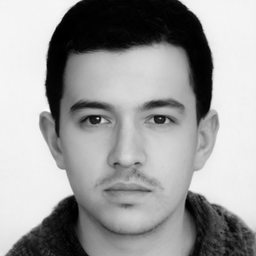

step  981/1000: percep_loss 0.17 latent_dist_reg 0.03 loss 0.22 
step  982/1000: percep_loss 0.17 latent_dist_reg 0.03 loss 0.22 
step  983/1000: percep_loss 0.17 latent_dist_reg 0.03 loss 0.22 
step  984/1000: percep_loss 0.17 latent_dist_reg 0.03 loss 0.22 
step  985/1000: percep_loss 0.17 latent_dist_reg 0.03 loss 0.22 
step  986/1000: percep_loss 0.17 latent_dist_reg 0.03 loss 0.22 
step  987/1000: percep_loss 0.17 latent_dist_reg 0.03 loss 0.22 
step  988/1000: percep_loss 0.17 latent_dist_reg 0.03 loss 0.22 
step  989/1000: percep_loss 0.17 latent_dist_reg 0.03 loss 0.22 
step  990/1000: percep_loss 0.17 latent_dist_reg 0.03 loss 0.22 
step  991/1000: percep_loss 0.17 latent_dist_reg 0.03 loss 0.22 
step  992/1000: percep_loss 0.17 latent_dist_reg 0.03 loss 0.22 
step  993/1000: percep_loss 0.17 latent_dist_reg 0.03 loss 0.22 
step  994/1000: percep_loss 0.17 latent_dist_reg 0.03 loss 0.22 
step  995/1000: percep_loss 0.17 latent_dist_reg 0.03 loss 0.22 
step  996/1000: percep_lo

In [ ]:
opt_losses = invert_image(degradation_mode=GRAYSCALE_DEGRADATION,
                          target_fname='/content/gdrive/MyDrive/Colorization/im2/my_face_aligned.png',
                          outdir='/content/gdrive/MyDrive/Colorization/im2',
                          seed=303,
                          num_steps=1000,
                          latent_dist_reg_weight=2)

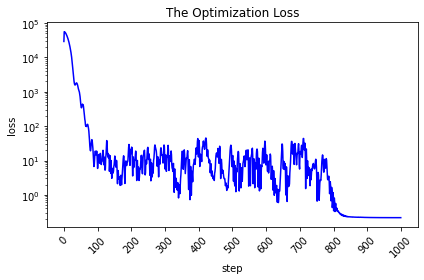

In [ ]:
plot_optimization_loss(opt_losses)

**The colorization on the given grayscale image of Alan Turing**


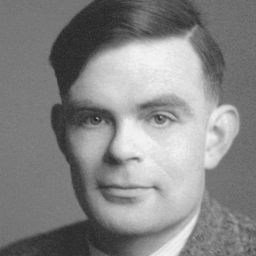
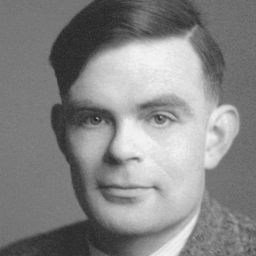
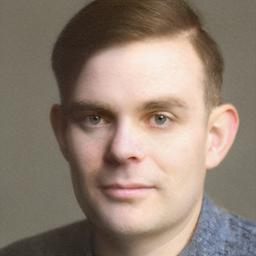
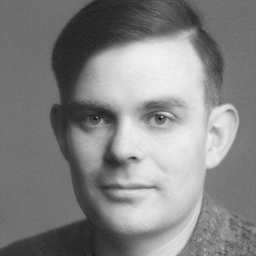

step 1481/1500: percep_loss 0.15 latent_dist_reg 0.06 loss 0.20 
step 1482/1500: percep_loss 0.15 latent_dist_reg 0.06 loss 0.20 
step 1483/1500: percep_loss 0.15 latent_dist_reg 0.06 loss 0.20 
step 1484/1500: percep_loss 0.15 latent_dist_reg 0.06 loss 0.20 
step 1485/1500: percep_loss 0.15 latent_dist_reg 0.06 loss 0.20 
step 1486/1500: percep_loss 0.15 latent_dist_reg 0.06 loss 0.20 
step 1487/1500: percep_loss 0.15 latent_dist_reg 0.06 loss 0.20 
step 1488/1500: percep_loss 0.15 latent_dist_reg 0.06 loss 0.20 
step 1489/1500: percep_loss 0.15 latent_dist_reg 0.06 loss 0.20 
step 1490/1500: percep_loss 0.15 latent_dist_reg 0.06 loss 0.20 
step 1491/1500: percep_loss 0.15 latent_dist_reg 0.06 loss 0.20 
step 1492/1500: percep_loss 0.15 latent_dist_reg 0.06 loss 0.20 
step 1493/1500: percep_loss 0.15 latent_dist_reg 0.06 loss 0.20 
step 1494/1500: percep_loss 0.15 latent_dist_reg 0.06 loss 0.20 
step 1495/1500: percep_loss 0.15 latent_dist_reg 0.06 loss 0.20 
step 1496/1500: percep_lo

In [ ]:
opt_losses = invert_image(degradation_mode=GRAYSCALE_DEGRADATION,
                          target_fname='/content/gdrive/MyDrive/IMPRO_EX5_2021/Alan Turing/alan_turing_grayscale.png',
                          outdir='/content/gdrive/MyDrive/IMPRO_EX5_2021/Alan Turing',
                          seed=303,
                          num_steps=1500,
                          latent_dist_reg_weight=1)

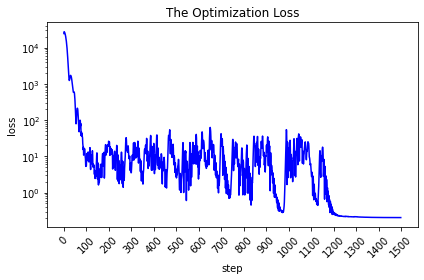

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_optimization_loss(opt_losses)

**Image Inpainting**


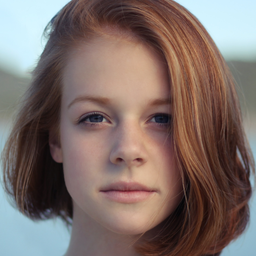
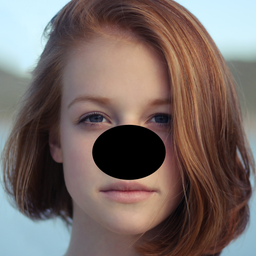
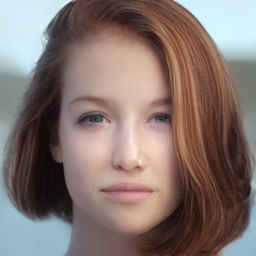
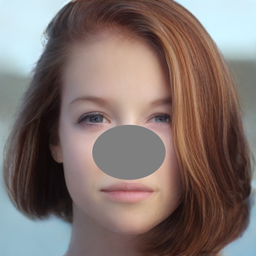

step  981/1000: percep_loss 0.12 latent_dist_reg 0.18 loss 0.15 
step  982/1000: percep_loss 0.12 latent_dist_reg 0.18 loss 0.15 
step  983/1000: percep_loss 0.12 latent_dist_reg 0.18 loss 0.15 
step  984/1000: percep_loss 0.12 latent_dist_reg 0.18 loss 0.15 
step  985/1000: percep_loss 0.12 latent_dist_reg 0.18 loss 0.15 
step  986/1000: percep_loss 0.12 latent_dist_reg 0.18 loss 0.15 
step  987/1000: percep_loss 0.12 latent_dist_reg 0.18 loss 0.15 
step  988/1000: percep_loss 0.12 latent_dist_reg 0.18 loss 0.15 
step  989/1000: percep_loss 0.12 latent_dist_reg 0.18 loss 0.15 
step  990/1000: percep_loss 0.12 latent_dist_reg 0.18 loss 0.15 
step  991/1000: percep_loss 0.12 latent_dist_reg 0.18 loss 0.15 
step  992/1000: percep_loss 0.12 latent_dist_reg 0.18 loss 0.15 
step  993/1000: percep_loss 0.12 latent_dist_reg 0.18 loss 0.15 
step  994/1000: percep_loss 0.12 latent_dist_reg 0.18 loss 0.15 
step  995/1000: percep_loss 0.12 latent_dist_reg 0.18 loss 0.15 
step  996/1000: percep_lo

In [ ]:
opt_losses = invert_image(degradation_mode=INPAINTING_DEGRADATION,
                          target_fname='/content/gdrive/MyDrive/inpainting/im1/Christopher_Campbell_aligned.png',
                          outdir='/content/gdrive/MyDrive/inpainting/im1',
                          mask_fname='/content/gdrive/MyDrive/inpainting/im1/Christopher_Campbell_mask.png',
                          seed=303,
                          num_steps=1000,
                          latent_dist_reg_weight=0.2)

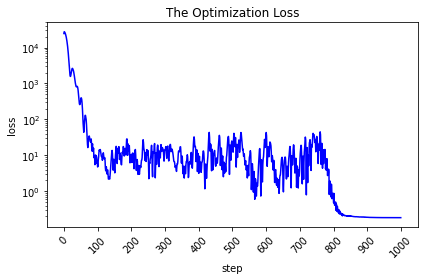

In [ ]:
plot_optimization_loss(opt_losses)


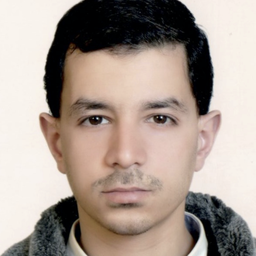
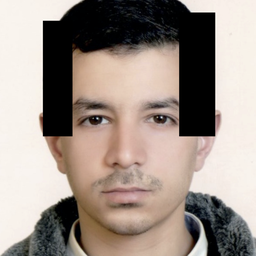
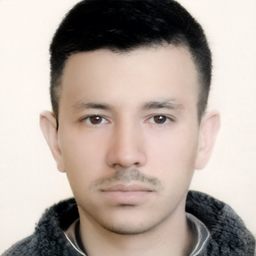
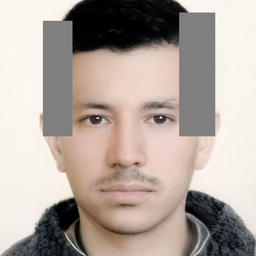

step  981/1000: percep_loss 0.16 latent_dist_reg 0.06 loss 0.21 
step  982/1000: percep_loss 0.16 latent_dist_reg 0.06 loss 0.21 
step  983/1000: percep_loss 0.16 latent_dist_reg 0.06 loss 0.21 
step  984/1000: percep_loss 0.16 latent_dist_reg 0.06 loss 0.21 
step  985/1000: percep_loss 0.16 latent_dist_reg 0.06 loss 0.21 
step  986/1000: percep_loss 0.16 latent_dist_reg 0.06 loss 0.21 
step  987/1000: percep_loss 0.16 latent_dist_reg 0.06 loss 0.21 
step  988/1000: percep_loss 0.16 latent_dist_reg 0.06 loss 0.21 
step  989/1000: percep_loss 0.16 latent_dist_reg 0.06 loss 0.21 
step  990/1000: percep_loss 0.16 latent_dist_reg 0.06 loss 0.21 
step  991/1000: percep_loss 0.16 latent_dist_reg 0.06 loss 0.21 
step  992/1000: percep_loss 0.16 latent_dist_reg 0.06 loss 0.21 
step  993/1000: percep_loss 0.16 latent_dist_reg 0.06 loss 0.21 
step  994/1000: percep_loss 0.16 latent_dist_reg 0.06 loss 0.21 
step  995/1000: percep_loss 0.16 latent_dist_reg 0.06 loss 0.21 
step  996/1000: percep_lo

In [ ]:
opt_losses = invert_image(degradation_mode=INPAINTING_DEGRADATION,
                          target_fname='/content/gdrive/MyDrive/inpainting/im2/my_face_aligned.png',
                          outdir='/content/gdrive/MyDrive/inpainting/im2',
                          mask_fname='/content/gdrive/MyDrive/inpainting/im2/my_face_mask.png',
                          seed=303,
                          num_steps=1000,
                          latent_dist_reg_weight=0.75)

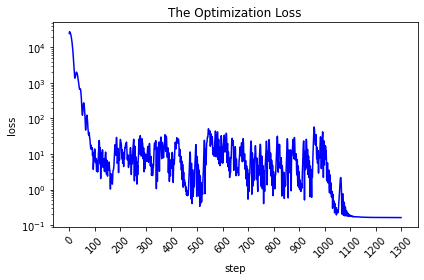

In [ ]:
plot_optimization_loss(opt_losses)

**The inpainting on the given masked image of Fei-Fei Li**


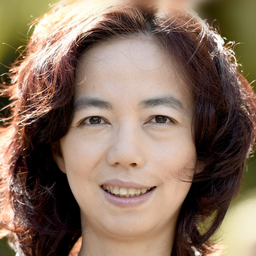
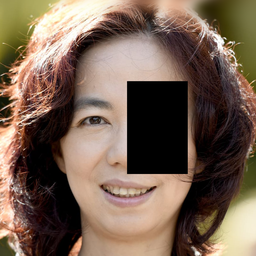
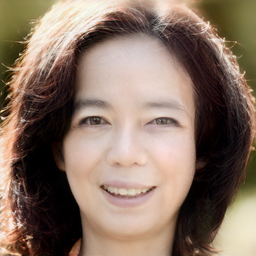
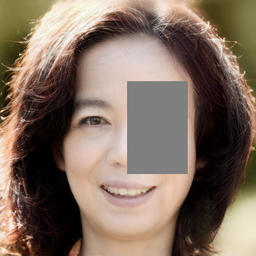

step  981/1000: percep_loss 0.18 latent_dist_reg 0.32 loss 0.21 
step  982/1000: percep_loss 0.18 latent_dist_reg 0.32 loss 0.21 
step  983/1000: percep_loss 0.18 latent_dist_reg 0.32 loss 0.21 
step  984/1000: percep_loss 0.18 latent_dist_reg 0.32 loss 0.21 
step  985/1000: percep_loss 0.18 latent_dist_reg 0.32 loss 0.21 
step  986/1000: percep_loss 0.18 latent_dist_reg 0.32 loss 0.21 
step  987/1000: percep_loss 0.18 latent_dist_reg 0.32 loss 0.21 
step  988/1000: percep_loss 0.18 latent_dist_reg 0.32 loss 0.21 
step  989/1000: percep_loss 0.18 latent_dist_reg 0.32 loss 0.21 
step  990/1000: percep_loss 0.18 latent_dist_reg 0.32 loss 0.21 
step  991/1000: percep_loss 0.18 latent_dist_reg 0.32 loss 0.21 
step  992/1000: percep_loss 0.18 latent_dist_reg 0.32 loss 0.21 
step  993/1000: percep_loss 0.18 latent_dist_reg 0.32 loss 0.21 
step  994/1000: percep_loss 0.18 latent_dist_reg 0.32 loss 0.21 
step  995/1000: percep_loss 0.18 latent_dist_reg 0.32 loss 0.21 
step  996/1000: percep_lo

In [ ]:
opt_losses = invert_image(degradation_mode=INPAINTING_DEGRADATION,
                          target_fname='/content/gdrive/MyDrive/inpainting/Fei-Fei Li/fei_fei_li_original.png',
                          outdir='/content/gdrive/MyDrive/inpainting/Fei-Fei Li',
                          mask_fname='/content/gdrive/MyDrive/inpainting/Fei-Fei Li/fei_fei_li_inpainting_mask.png',
                          seed=303,
                          num_steps=1000,
                          latent_dist_reg_weight=0.1)

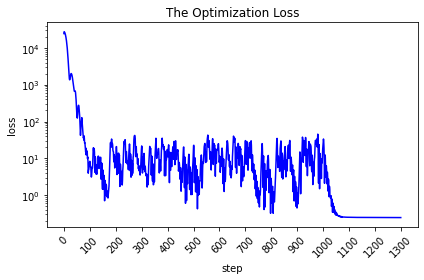

In [ ]:
plot_optimization_loss(opt_losses)